In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import project_func as pf
import os
import glob
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
project_root = "/Users/jmccarty/GitHub/cmip6_and_buildings"

climate_zones_shp = os.path.join(project_root, 'notebooks', 'input_data', 'climate_zones', 'ClimateZones.shp')

zones = gpd.read_file(climate_zones_shp)
zones = zones[~pd.isna(zones['State'])]
zones = zones[~pd.isna(zones['IECC21'])]
zones['Moisture21'] = zones['Moisture21'].fillna('A').str.lower()
zones['IECC21'] = zones['IECC21'].astype(int)
# change LA to 3bc
row_idx = zones[zones['Country']=='Los Angeles'].index[0]
zones.loc[row_idx,'Moisture21'] = 'bc'
zones['climate_zone'] = zones['IECC21'].astype(str) + zones['Moisture21']
zones = zones[zones['climate_zone']!='5c']
# zones = zones[zones['State']!='Hawaii']
zones = zones.to_crs(epsg=2163)
zones['cz_color'] = zones['climate_zone'].map(pf.get_color_dict())
# zones['grid_emissions'] = zones['climate_zone'].map(grid_ann_cz)


In [3]:
def extract_historical(df, search_cat, search_for):
    if search_cat == 'vintage':
        code_locator = 0
    elif search_cat == 'cz':
        code_locator = 1
    elif search_cat == 'scen_year':
        code_locator = 2
    elif search_cat == 'bldg':
        code_locator = 3
    else:
        print('search_for arg must in vintage, cz, scen_year, or bldg')
    final_idx = []
    null_idx = []
    for idx in list(df.index):
        if idx.split("_")[code_locator]==str(search_for):
            final_idx.append(idx)
        else:
            null_idx.append(idx)
            
    return final_idx, null_idx

def reduce_key_scen_year(search_key):
    return "_".join([i for n, i in enumerate(search_key.split("_")) if n!=2])

def find_matching_key(search_key, search_set):
    search_set_reduced = [reduce_key_scen_year(k) for k in search_set]
    search_set = list(zip(search_set_reduced, search_set))

    # def find_match(search_key, search_set):
    reduced_key = reduce_key_scen_year(search_key)

    search_match = [k for r, k in search_set if r==reduced_key]
    return search_match

# Annual Results

In [4]:
annual_file = f"/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/output_data/all_annual_data.csv"

kpi_list = list(pf.reverse_dict(pf.all_kpi).values())
df = pd.read_csv(annual_file, index_col='Unnamed: 0').rename(columns=pf.reverse_dict(pf.all_kpi))



hist_idx, null_idx = extract_historical(df, 'scen_year', 0)
hist_df = df.loc[hist_idx]
fut_df = df.loc[null_idx]


delta_dict = {}
delta_abs_dict = {}
for col in kpi_list:
    delta_dict[col] = {}
    delta_abs_dict[col] = {}
    for idx_key in fut_df.index:
        match_hist_key = find_matching_key(idx_key, hist_df.index.tolist())
        hist_val = hist_df.loc[match_hist_key][col].values[0]
        fut_val = fut_df.loc[idx_key][col]
        
        col_delta = round(100*((fut_val - hist_val) / (hist_val + 1e-10)),1)
        delta_dict[col].update({idx_key:col_delta})
        
        delta_abs_dict[col].update({idx_key:fut_val - hist_val})
        
delta_df = pd.DataFrame(delta_dict)
delta_df = delta_df.join(pf.expand_code_idx_to_df(delta_df, pf.all_dict, pf.code_names))


delta_df_abs = pd.DataFrame(delta_abs_dict)
delta_df_abs = delta_df_abs.join(pf.expand_code_idx_to_df(delta_df_abs, pf.all_dict, pf.code_names))

In [8]:
zones[net_cols].describe()

,ssp126_op_em_kgco2_net,ssp245_op_em_kgco2_net,ssp585_op_em_kgco2_net
count,3133.000000,3133.000000,3133.000000
mean,3.768529,4.489148,5.740089
std,3.239679,3.977945,5.226606
min,-3.900000,-3.800000,-4.100000
25%,1.900000,1.900000,2.100000
50%,3.300000,4.300000,5.200000
75%,7.600000,8.700000,11.400000
max,14.900000,18.800000,23.300000


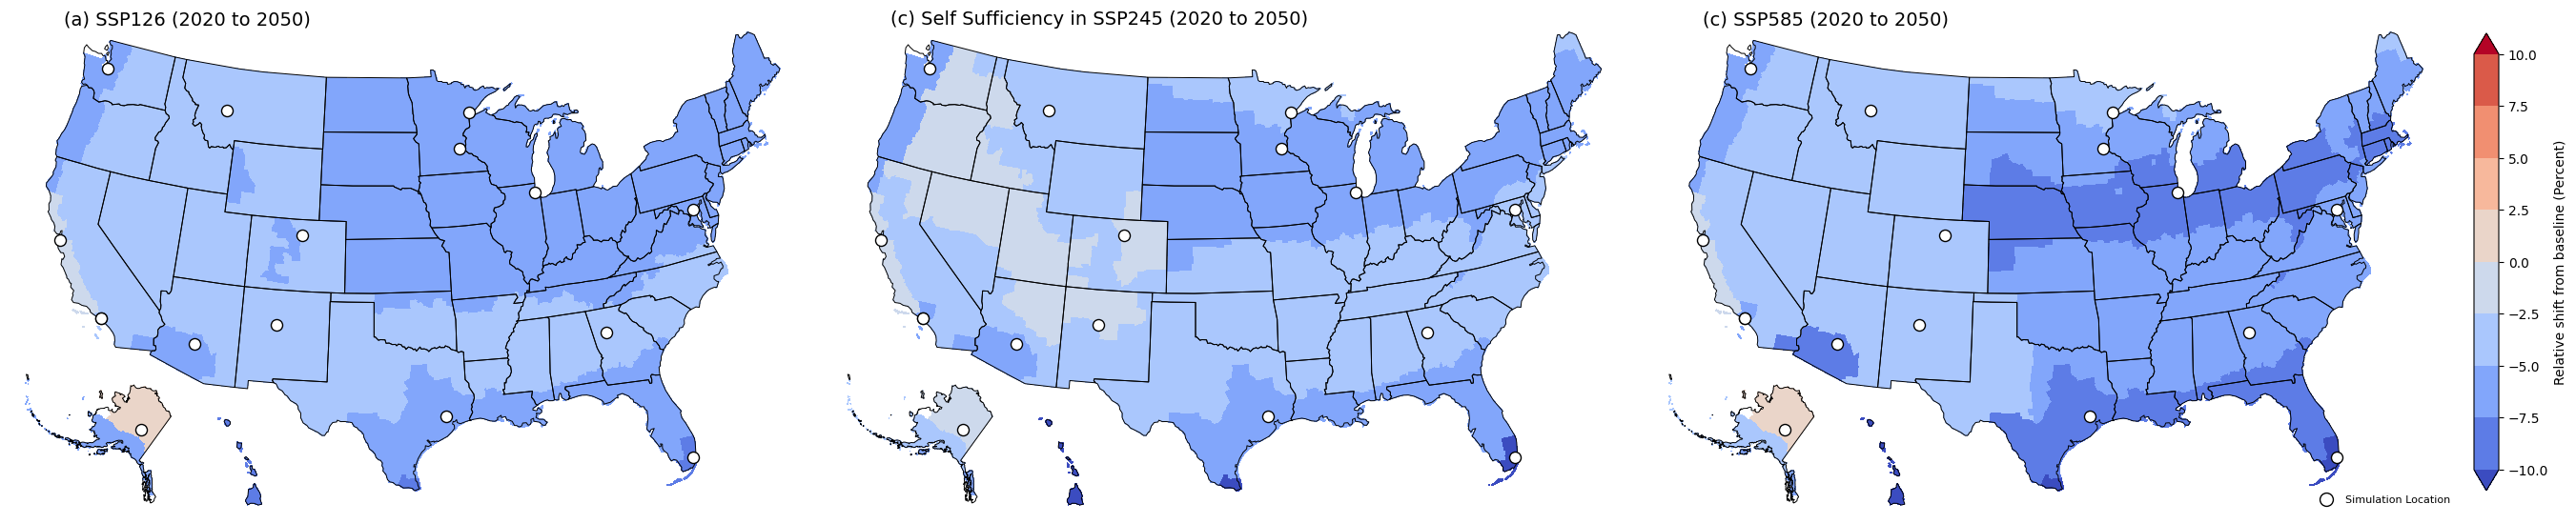

In [26]:
bldg_type = 'RefBldgMediumOffice' # 'RefBldgMediumOffice' #RefBldgMidriseApartment
col =  'self_suff_pct' #'geff_irrad_kwh'#'Time Setpoint Not Met During Occupied Cooling'
year = 2050

net_cols = [] 

for scenario in pf.get_scenarios():
        if scenario=='historical':
                pass
        else:
                net_col = f'{scenario}_{col}_net'
                net_cols.append(net_col)
                zones[net_col] = pf.combine_result_to_zones(pf.all_dict, pf.code_names, zones,
                                                            delta_df, col, 'new', f'{scenario}_{year}', bldg_type)

lgd_label = 'Relative shift from baseline (Percent)'

# lrgst_result = max(abs(zones[net_cols].min().min()), abs(zones[net_cols].max().max()))
lrgst_result = 10 #zones[net_cols].describe().loc['min'].max()
vmin = -1 * lrgst_result
vmax = abs(vmin)
cmap = mpl.cm.coolwarm
cmap_steps = 10
if lrgst_result==0:
        bounds = [-1,1]
elif vmin==vmax:
        bounds1 = np.linspace(vmin*-1,0,int(cmap_steps/2))
        bounds2 = np.linspace(0,vmax,int(cmap_steps/2))
        bounds = list(bounds1[0:int((cmap_steps/2)-1)]) + list(bounds2)
else:        
        bounds1 = np.linspace(vmin,0,int(cmap_steps/2))
        bounds2 = np.linspace(0,vmax,int(cmap_steps/2))
        bounds = list(bounds1[0:int((cmap_steps/2)-1)]) + list(bounds2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(26,12))
pf.plot_us_map_heatmap(zones, net_cols[0], lgd_label, lgd=False, ax=ax1, cmap=cmap, norm=norm,
        vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, net_cols[1], lgd_label, lgd=False, ax=ax2, cmap=cmap, norm=norm,
        vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, net_cols[2], lgd_label, lgd=False, ax=ax3, cmap=cmap, norm=norm,
        vmin=vmin, vmax=vmax)
# patch_col = ax1.collections[0]
# cb = fig.colorbar(patch_col, ax=ax3, shrink=0.5, extend='max')

ax1.text(0.22, 0.98, f'(a) SSP126 (2020 to {year})', fontsize=14,
        horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax2.text(1.35, 0.98, f'(c) Self Sufficiency in SSP245 (2020 to {year})', fontsize=14,
        horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax3.text(2.25, 0.98, f'(c) SSP585 (2020 to {year})', fontsize=14,
        horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

title_text = f"Percent change in {pf.get_kpi_descriptions()[col].lower()} - ({col})"
# ax2.text(1.52, 1.05, title_text, fontsize=18, fontweight='bold',
#         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


cbar_ax = fig.add_axes([1.0, 0.30, 0.01, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)#plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cbar_ax, extend='both', label=lgd_label)

lgd_el_tmy = pf.build_lgd(
        [('white', 'k')], ['Simulation Location'], element_type='marker')
ax3.legend(handles=lgd_el_tmy, loc='lower right', frameon=False, title='',
                        fontsize=8)

plot_dir = f"/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/plots/paper_plots"
if os.path.exists(plot_dir):
        pass
else:
        os.makedirs(plot_dir)
fig.savefig(os.path.join(plot_dir,f"pct_change_{bldg_type}_{col}_{year}.png"),
            dpi=300,bbox_inches="tight")
# plt.close()

In [227]:
bldg_type = 'RefBldgMidriseApartment' # 'RefBldgMediumOffice' #RefBldgMidriseApartment
for col in kpi_list:
        net_cols = [] 

        for scenario in pf.get_scenarios():
                if scenario=='historical':
                        pass
                else:
                        net_col = f'{scenario}_{col}_net'
                        net_cols.append(net_col)
                        zones[net_col] = pf.combine_result_to_zones(pf.all_dict, pf.code_names, zones,
                                                                    delta_df, col, 'new', f'{scenario}_2080', bldg_type)

        lgd_label = 'Relative shift from baseline (Percent)'

        # lrgst_result = max(abs(zones[net_cols].min().min()), abs(zones[net_cols].max().max()))
        lrgst_result = zones[net_cols].describe().loc['75%'].max()
        vmin = -1 * lrgst_result
        vmax = abs(vmin)
        cmap = mpl.cm.coolwarm
        if lrgst_result==0:
                bounds = [-1,1]
        elif vmin==vmax:
                bounds1 = np.linspace(vmin*-1,0,5)
                bounds2 = np.linspace(0,vmax,5)
                bounds = list(bounds1[0:4]) + list(bounds2)
        else:        
                bounds1 = np.linspace(vmin,0,5)
                bounds2 = np.linspace(0,vmax,5)
                bounds = list(bounds1[0:4]) + list(bounds2)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(26,12))
        pf.plot_us_map_heatmap(zones, net_cols[0], lgd_label, lgd=False, ax=ax1, cmap=cmap, norm=norm,
                vmin=vmin, vmax=vmax)
        pf.plot_us_map_heatmap(zones, net_cols[1], lgd_label, lgd=False, ax=ax2, cmap=cmap, norm=norm,
                vmin=vmin, vmax=vmax)
        pf.plot_us_map_heatmap(zones, net_cols[2], lgd_label, lgd=False, ax=ax3, cmap=cmap, norm=norm,
                vmin=vmin, vmax=vmax)
        # patch_col = ax1.collections[0]
        # cb = fig.colorbar(patch_col, ax=ax3, shrink=0.5, extend='max')

        ax1.text(0.22, 0.98, '(a) SSP126 (2020 to 2080)', fontsize=14,
                horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
        ax2.text(1.23, 0.98, '(b) SSP245 (2020 to 2080)', fontsize=14,
                horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
        ax3.text(2.25, 0.98, '(c) SSP585 (2020 to 2080)', fontsize=14,
                horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

        title_text = f"Percent change in {pf.get_kpi_descriptions()[col].lower()} - ({col})"
        ax2.text(1.52, 1.05, title_text, fontsize=18, fontweight='bold',
                horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


        cbar_ax = fig.add_axes([1.0, 0.30, 0.01, 0.4])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)#plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        fig.colorbar(sm, cax=cbar_ax, extend='both', label=lgd_label)

        lgd_el_tmy = pf.build_lgd(
                [('white', 'k')], ['Simulation Location'], element_type='marker')
        ax3.legend(handles=lgd_el_tmy, loc='lower right', frameon=False, title='',
                                fontsize=8)

        plot_dir = f"/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/plots/annual_shift_plots/{bldg_type}"
        if os.path.exists(plot_dir):
                pass
        else:
                os.makedirs(plot_dir)
        fig.savefig(os.path.join(plot_dir,f"pct_change_{col}.png"),
                    dpi=300,bbox_inches="tight")
        plt.close()

# Seasonal Results

In [240]:
season = "Winter"
bldg_type = 'RefBldgMediumOffice' # 'RefBldgMediumOffice' #RefBldgMidriseApartment

seasonal_file = f"/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/output_data/seasonal/{season}.csv"
df = pd.read_csv(seasonal_file, index_col='Unnamed: 0').rename(columns=pf.reverse_dict(pf.map_perf_metrics))

hist_idx, null_idx = extract_historical(df, 'scen_year', 0)
hist_df = df.loc[hist_idx]
fut_df = df.loc[null_idx]


delta_dict = {}
for col in fut_df.columns:
    delta_dict[col] = {}
    for idx_key in fut_df.index:
        match_hist_key = find_matching_key(idx_key, hist_df.index.tolist())
        hist_val = hist_df.loc[match_hist_key][col].values[0]
        fut_val = fut_df.loc[idx_key][col]
        
        col_delta = round(100*((fut_val - hist_val) / (hist_val + 1e-10)),1)
        delta_dict[col].update({idx_key:col_delta})
        
delta_df = pd.DataFrame(delta_dict)
delta_df = delta_df.join(pf.expand_code_idx_to_df(delta_df, pf.all_dict, pf.code_names))


for col in list(pf.reverse_dict(pf.map_perf_metrics).values()):
        net_cols = [] 

        for scenario in pf.get_scenarios():
                if scenario=='historical':
                        pass
                else:
                        net_col = f'{scenario}_{col}_net'
                        net_cols.append(net_col)
                        zones[net_col] = pf.combine_result_to_zones(pf.all_dict, pf.code_names, zones,
                                                                    delta_df, col, 'new', f'{scenario}_2080', bldg_type)

        lgd_label = 'Relative shift from baseline (Percent)'

        lrgst_result = max(abs(zones[net_cols].min().min()), abs(zones[net_cols].max().max()))
        vmin = -1 * lrgst_result
        vmax = abs(vmin)
        cmap = mpl.cm.coolwarm
        if lrgst_result==0:
                bounds = [-1,1]
        elif vmin==vmax:
                bounds1 = np.linspace(vmin*-1,0,5)
                bounds2 = np.linspace(0,vmax,5)
                bounds = list(bounds1[0:4]) + list(bounds2)
        else:        
                bounds1 = np.linspace(vmin,0,5)
                bounds2 = np.linspace(0,vmax,5)
                bounds = list(bounds1[0:4]) + list(bounds2)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(26,12))
        pf.plot_us_map_heatmap(zones, net_cols[0], lgd_label, lgd=False, ax=ax1, cmap=cmap, norm=norm,
                vmin=vmin, vmax=vmax)
        pf.plot_us_map_heatmap(zones, net_cols[1], lgd_label, lgd=False, ax=ax2, cmap=cmap, norm=norm,
                vmin=vmin, vmax=vmax)
        pf.plot_us_map_heatmap(zones, net_cols[2], lgd_label, lgd=False, ax=ax3, cmap=cmap, norm=norm,
                vmin=vmin, vmax=vmax)
        # patch_col = ax1.collections[0]
        # cb = fig.colorbar(patch_col, ax=ax3, shrink=0.5, extend='max')

        ax1.text(0.22, 0.98, '(a) SSP126 (2020 to 2080)', fontsize=14,
                horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
        ax2.text(1.23, 0.98, '(b) SSP245 (2020 to 2080)', fontsize=14,
                horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
        ax3.text(2.25, 0.98, '(c) SSP585 (2020 to 2080)', fontsize=14,
                horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

        title_text = f"Percent change in {pf.get_kpi_descriptions()[col].lower()} - ({col})"
        ax2.text(1.52, 1.05, title_text, fontsize=18, fontweight='bold',
                horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


        cbar_ax = fig.add_axes([1.0, 0.30, 0.01, 0.4])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)#plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        fig.colorbar(sm, cax=cbar_ax, extend='both', label=lgd_label)

        lgd_el_tmy = pf.build_lgd(
                [('white', 'k')], ['Simulation Location'], element_type='marker')
        ax3.legend(handles=lgd_el_tmy, loc='lower right', frameon=False, title='',
                                fontsize=8)

        plot_dir = f"/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/plots/{season}_shift_plots/{bldg_type}"
        if os.path.exists(plot_dir):
                pass
        else:
                os.makedirs(plot_dir)
        fig.savefig(os.path.join(plot_dir,f"pct_change_{col}.png"),
                    dpi=300,bbox_inches="tight")
        plt.close()

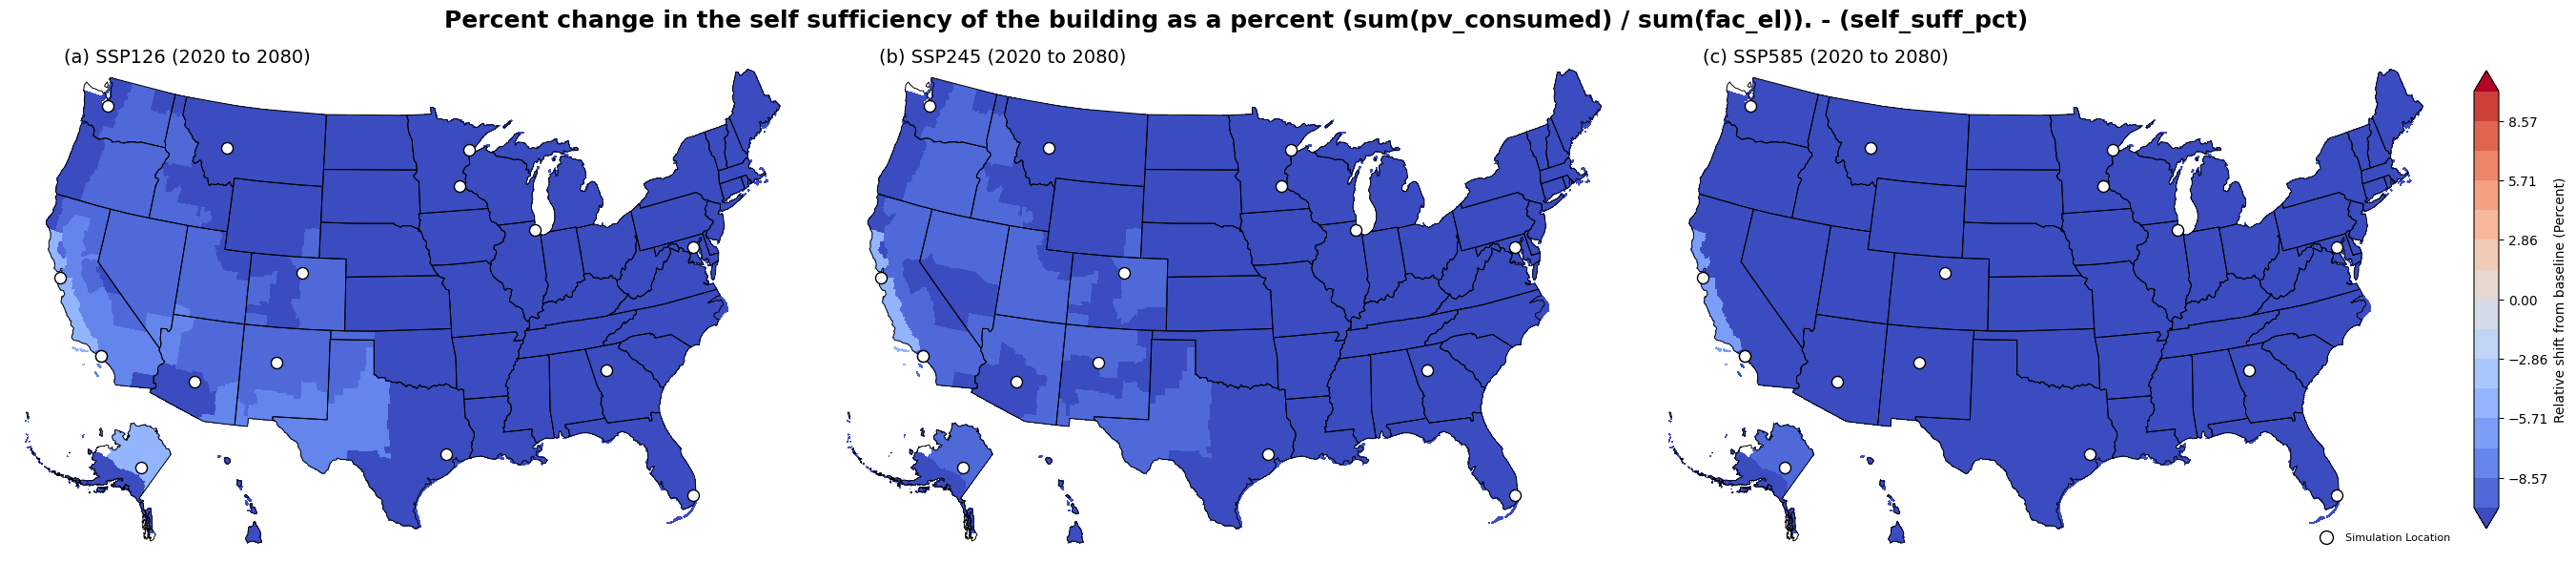

In [29]:
season = "Summer"
bldg_type = 'RefBldgMediumOffice' # 'RefBldgMediumOffice' #RefBldgMidriseApartment

seasonal_file = f"/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/output_data/seasonal/{season}.csv"
df = pd.read_csv(seasonal_file, index_col='Unnamed: 0').rename(columns=pf.reverse_dict(pf.map_perf_metrics))

hist_idx, null_idx = extract_historical(df, 'scen_year', 0)
hist_df = df.loc[hist_idx]
fut_df = df.loc[null_idx]


delta_dict = {}
delta_abs_dict = {}
for col in fut_df.columns:
    delta_dict[col] = {}
    delta_abs_dict[col] = {}
    for idx_key in fut_df.index:
        match_hist_key = find_matching_key(idx_key, hist_df.index.tolist())
        hist_val = hist_df.loc[match_hist_key][col].values[0]
        fut_val = fut_df.loc[idx_key][col]
        
        col_delta = round(100*((fut_val - hist_val) / (hist_val + 1e-10)),1)
        delta_dict[col].update({idx_key:col_delta})
        delta_abs_dict[col].update({idx_key:fut_val - hist_val})
        
delta_df = pd.DataFrame(delta_dict)
delta_df = delta_df.join(pf.expand_code_idx_to_df(delta_df, pf.all_dict, pf.code_names))


delta_df_abs = pd.DataFrame(delta_abs_dict)
delta_df_abs = delta_df_abs.join(pf.expand_code_idx_to_df(delta_df_abs, pf.all_dict, pf.code_names))
        
col = 'self_suff_pct' # 'geff_irrad_kwh'# 'self_suff_pct'

net_cols = [] 
for scenario in pf.get_scenarios():
        if scenario=='historical':
                pass
        else:
                net_col = f'{scenario}_{col}_net'
                net_cols.append(net_col)
                zones[net_col] = pf.combine_result_to_zones(pf.all_dict, pf.code_names, zones,
                                                                delta_df, col, 'new', f'{scenario}_2080', bldg_type)

lgd_label = 'Relative shift from baseline (Percent)'

lrgst_result = 10#max(abs(zones[net_cols].min().min()), abs(zones[net_cols].max().max()))
vmin = -1 * lrgst_result
vmax = abs(vmin)
cmap = mpl.cm.coolwarm
cmap_steps = 16
if lrgst_result==0:
        bounds = [-1,1]
elif vmin==vmax:
        bounds1 = np.linspace(vmin*-1,0,int(cmap_steps/2))
        bounds2 = np.linspace(0,vmax,int(cmap_steps/2))
        bounds = list(bounds1[0:int((cmap_steps/2)-1)]) + list(bounds2)
else:        
        bounds1 = np.linspace(vmin,0,int(cmap_steps/2))
        bounds2 = np.linspace(0,vmax,int(cmap_steps/2))
        bounds = list(bounds1[0:int((cmap_steps/2)-1)]) + list(bounds2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(26,12))
pf.plot_us_map_heatmap(zones, net_cols[0], lgd_label, lgd=False, ax=ax1, cmap=cmap, norm=norm,
        vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, net_cols[1], lgd_label, lgd=False, ax=ax2, cmap=cmap, norm=norm,
        vmin=vmin, vmax=vmax)
pf.plot_us_map_heatmap(zones, net_cols[2], lgd_label, lgd=False, ax=ax3, cmap=cmap, norm=norm,
        vmin=vmin, vmax=vmax)
# patch_col = ax1.collections[0]
# cb = fig.colorbar(patch_col, ax=ax3, shrink=0.5, extend='max')

ax1.text(0.22, 0.98, '(a) SSP126 (2020 to 2080)', fontsize=14,
        horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax2.text(1.23, 0.98, '(b) SSP245 (2020 to 2080)', fontsize=14,
        horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax3.text(2.25, 0.98, '(c) SSP585 (2020 to 2080)', fontsize=14,
        horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

title_text = f"Percent change in {pf.get_kpi_descriptions()[col].lower()} - ({col})"
ax2.text(1.52, 1.05, title_text, fontsize=18, fontweight='bold',
        horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


cbar_ax = fig.add_axes([1.0, 0.30, 0.01, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)#plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cbar_ax, extend='both', label=lgd_label)

lgd_el_tmy = pf.build_lgd(
        [('white', 'k')], ['Simulation Location'], element_type='marker')
ax3.legend(handles=lgd_el_tmy, loc='lower right', frameon=False, title='',
                        fontsize=8)

plot_dir = f"/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/plots/paper_plots"
if os.path.exists(plot_dir):
        pass
else:
        os.makedirs(plot_dir)
fig.savefig(os.path.join(plot_dir,f"pct_change_{bldg_type}_{col}_{season}_{bldg_type}.png"),
            dpi=300,bbox_inches="tight")
# plt.close()

# Bar Plots - PPLT

In [30]:
import seaborn as sns
import proplot as pplt

def make_delta_dfs(season):
    seasonal_file = f"/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/output_data/seasonal/{season}.csv"
    df = pd.read_csv(seasonal_file, index_col='Unnamed: 0').rename(columns=pf.reverse_dict(pf.map_perf_metrics))

    hist_idx, null_idx = extract_historical(df, 'scen_year', 0)
    # get only historical
    hist_df = df.loc[hist_idx]
    # get all future
    fut_df = df.loc[null_idx]


    delta_dict = {}
    delta_abs_dict = {}
    for col in fut_df.columns:
        delta_dict[col] = {}
        delta_abs_dict[col] = {}
        for idx_key in fut_df.index:
            match_hist_key = find_matching_key(idx_key, hist_df.index.tolist())
            hist_val = hist_df.loc[match_hist_key][col].values[0]
            fut_val = fut_df.loc[idx_key][col]
            
            col_delta = round(100*((fut_val - hist_val) / (hist_val + 1e-10)),1)
            delta_dict[col].update({idx_key:col_delta})
            delta_abs_dict[col].update({idx_key:fut_val - hist_val})
            
    delta_df = pd.DataFrame(delta_dict)
    delta_df = delta_df.join(pf.expand_code_idx_to_df(delta_df, pf.all_dict, pf.code_names))


    delta_df_abs = pd.DataFrame(delta_abs_dict)
    delta_df_abs = delta_df_abs.join(pf.expand_code_idx_to_df(delta_df_abs, pf.all_dict, pf.code_names))
    return delta_df, delta_df_abs

def create_plot_df(which_delta, zones, col, bldg, year):
    net_cols = [] 
    for scenario in pf.get_scenarios():
            if scenario=='historical':
                    pass
            else:
                    net_col = f'{scenario}_{col}_net'
                    net_cols.append(net_col)
                    zones[net_col] = pf.combine_result_to_zones(pf.all_dict, pf.code_names, zones,
                                                                which_delta, col, 'new', f'{scenario}_{year}', 
                                                                bldg)
    plot_df = zones[net_cols+['climate_zone']].copy()
    plot_df['bldg_type'] = bldg
    return plot_df

scenario = 'ssp245'
col = 'self_suff_pct'
year = 2050
plot_dfs = []
for season in ['Spring',"Summer",'Fall',"Winter"]:

    delta_rel, delta_abs = make_delta_dfs(season)
    which_delta = delta_rel
    off_med = create_plot_df(which_delta, zones, col, 'RefBldgMediumOffice', year)
    ap_mid = create_plot_df(which_delta, zones, col, 'RefBldgMidriseApartment', year)
    scenario_col = [c for c in ap_mid.columns if scenario in c]
    plot_cols = scenario_col+['climate_zone']
    off_plot = off_med[plot_cols].groupby('climate_zone').mean().rename(columns={scenario_col[0]:'self_suff_shift'}).reset_index()
    off_plot['scenario'] = scenario
    off_plot['year'] = year
    off_plot['bldg_type'] = 'RefBldgMediumOffice'
    
    ap_plot = ap_mid[plot_cols].groupby('climate_zone').mean().rename(columns={scenario_col[0]:'self_suff_shift'}).reset_index()
    ap_plot['scenario'] = scenario
    ap_plot['year'] = year
    ap_plot['bldg_type'] = 'RefBldgMidriseApartment'
    plot_df = pd.concat([off_plot,ap_plot])
    plot_df['season'] = season
    plot_dfs.append(plot_df)
    
plot_df = pd.concat(plot_dfs)

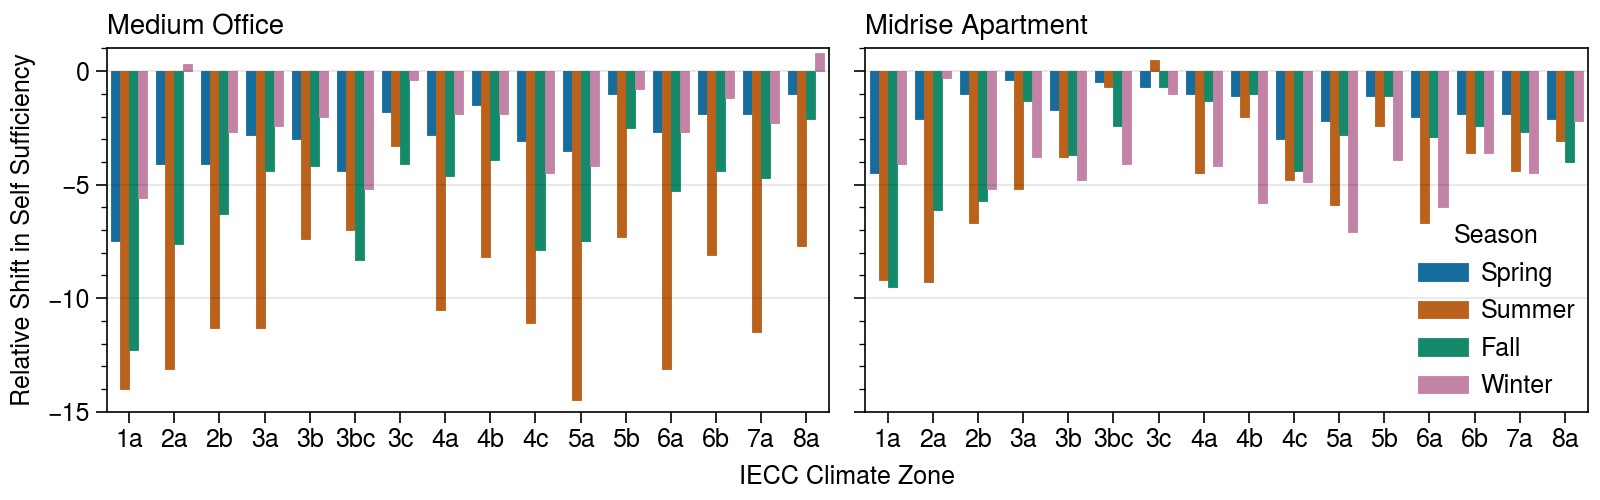

In [56]:
fig, axe = pplt.subplots(ncols=2,figsize=(8,2.5), facecolor='white')

bldg_types = [('RefBldgMediumOffice','Medium Office'),('RefBldgMidriseApartment', 'Midrise Apartment')]
for n,ax in enumerate(axe):
    plot_bldg = plot_df[plot_df['bldg_type']==bldg_types[n][0]]
    
    sns.barplot(x='climate_zone',
                y='self_suff_shift',
                data=plot_bldg, 
                hue='season', 
                ax=ax,
                legend=False,
                )
    ax.format(ltitle=bldg_types[n][1])
    ax.legend([],[], frameon=False)
    handles, labels = ax.get_legend_handles_labels()
    


axe.format(ylim=(-15,1),
           ylocator=5,
           xlocator=1,
           xtickminor=False,
           xgridminor=False,
           ylabel='Relative Shift in Self Sufficiency',
           xlabel='IECC Climate Zone')
ax.legend(handles=handles,labels=labels,
          loc='lr',ncols=1,label='Season', frameon=False)

plot_dir = f"/Users/jmccarty/GitHub/cmip6_and_buildings/notebooks/plots/paper_plots"
if os.path.exists(plot_dir):
        pass
else:
        os.makedirs(plot_dir)
fig.savefig(os.path.join(plot_dir,f"self_suff_change_all_seaons_all_building.png"),
            dpi=600,bbox_inches="tight")